In [130]:
# Import Libraries

import os
import torch
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, Subset

from PIL import Image
from PIL import ImageFilter
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from torch.optim import lr_scheduler

from tkinter import filedialog, Tk

from gradcam import GradCAM, GradCAMpp
from gradcam.utils import visualize_cam

import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
# Specify the path to the locally saved dataset
train_data_dir = '/Users/savin/Desktop/FYP/Implementation/kaggle_dataset/AugmentedAlzheimerDataset'
train_dataset = datasets.ImageFolder(train_data_dir)

In [54]:
# Preprocessing steps used for imagenet dataset with the original AlexNet model
preprocess_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.Grayscale(num_output_channels=1),  
    transforms.Lambda(lambda img: img.filter(ImageFilter.UnsharpMask(radius=2, percent=200, threshold=3))),
    transforms.ToTensor(),  # Then convert to Tensor
    # transforms.Normalize(mean=[mean_value], std=[std_value])
])

# preprocessed dataset
preprocessed_dataset = datasets.ImageFolder(root=train_data_dir, transform=preprocess_transform)

# DataLoader for the dataset
data_loader = DataLoader(preprocessed_dataset, batch_size=32, shuffle=True)

In [55]:
# Paths for each class
MildDemented = '/Users/savin/Desktop/FYP/Implementation/kaggle_dataset/AugmentedAlzheimerDataset/MildDemented'
ModerateDemented = '/Users/savin/Desktop/FYP/Implementation/kaggle_dataset/AugmentedAlzheimerDataset/ModerateDemented'
NonDemented = '/Users/savin/Desktop/FYP/Implementation/kaggle_dataset/AugmentedAlzheimerDataset/NonDemented'
VeryMildDemented = '/Users/savin/Desktop/FYP/Implementation/kaggle_dataset/AugmentedAlzheimerDataset/VeryMildDemented'

count_MildDemented = len(os.listdir(MildDemented))
count_ModerateDemented = len(os.listdir(ModerateDemented))
count_NonDemented = len(os.listdir(NonDemented))
count_VeryMildDemented = len(os.listdir(VeryMildDemented))

# Printing the MRI counts
print(f"Number of images in MildDemented: {count_MildDemented}")
print(f"Number of images in ModerateDemented: {count_ModerateDemented}")
print(f"Number of images in NonDemented: {count_NonDemented}")
print(f"Number of images in VeryMildDemented: {count_VeryMildDemented}")

print(f"\nTotal MRIs in the dataset = {count_MildDemented+count_ModerateDemented+count_NonDemented+count_VeryMildDemented}" )

Number of images in MildDemented: 8960
Number of images in ModerateDemented: 6464
Number of images in NonDemented: 9600
Number of images in VeryMildDemented: 8960

Total MRIs in the dataset = 33984


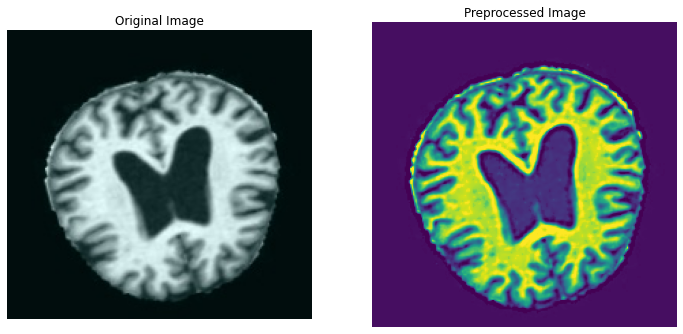

In [56]:
# Sample MRI before and after preprocessing

sample_image_path = os.path.join(MildDemented, os.listdir(MildDemented)[5])

original_image = Image.open(sample_image_path)

# Apply the preprocessing transforms
preprocessed_image = preprocess_transform(original_image)

preprocessed_image = transforms.ToPILImage()(preprocessed_image)

# Display the images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(preprocessed_image)
plt.title("Preprocessed Image")
plt.axis('off')

plt.show()

In [15]:
# Dataset splitting 

train_size = int(0.70 * len(preprocessed_dataset))
val_size = int(0.15 * len(preprocessed_dataset))
test_size = len(preprocessed_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(preprocessed_dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}

In [58]:
# custom model inspired by the AlexNet architecture 

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(negative_slope=0.01, inplace=True)

    def forward(self, x):
        return self.leakyrelu(self.bn(self.conv(x)))
    
class Bottleneck(nn.Module):
    def __init__(self, in_channels, inter_channels, out_channels):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, inter_channels, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(inter_channels)
        self.conv2 = nn.Conv2d(inter_channels, inter_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(inter_channels)
        self.conv3 = nn.Conv2d(inter_channels, out_channels, kernel_size=1)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(negative_slope=0.01, inplace=True)

        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        residual = self.shortcut(x)
        x = self.leakyrelu(self.bn1(self.conv1(x)))
        x = self.leakyrelu(self.bn2(self.conv2(x)))
        x = self.conv3(x)
        x = self.bn3(x)
        x += residual
        return self.leakyrelu(x)
    
class CustomAlexNet(nn.Module):
    def __init__(self, num_classes=4):
        super(CustomAlexNet, self).__init__()
        self.features = nn.Sequential(
            ConvBlock(1, 64, kernel_size=11, stride=4, padding=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            ConvBlock(64, 192, kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            Bottleneck(192, 256, 384),
            ConvBlock(384, 256, kernel_size=3, stride=1, padding=1),
            ConvBlock(256, 256, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        output_size = 256 * 6 * 6 

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(output_size, 4096),
            nn.LeakyReLU(0.01),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.LeakyReLU(0.01),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.classifier(x)
        return x


# create an instance of the custom AlexNet model
model1 = CustomAlexNet(num_classes=4)

In [59]:
summary(model1, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]           7,808
       BatchNorm2d-2           [-1, 64, 55, 55]             128
         LeakyReLU-3           [-1, 64, 55, 55]               0
         ConvBlock-4           [-1, 64, 55, 55]               0
         MaxPool2d-5           [-1, 64, 27, 27]               0
            Conv2d-6          [-1, 192, 27, 27]         307,392
       BatchNorm2d-7          [-1, 192, 27, 27]             384
         LeakyReLU-8          [-1, 192, 27, 27]               0
         ConvBlock-9          [-1, 192, 27, 27]               0
        MaxPool2d-10          [-1, 192, 13, 13]               0
           Conv2d-11          [-1, 384, 13, 13]          74,112
      BatchNorm2d-12          [-1, 384, 13, 13]             768
           Conv2d-13          [-1, 256, 13, 13]          49,408
      BatchNorm2d-14          [-1, 256,

In [60]:
print(model1)

CustomAlexNet(
  (features): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ConvBlock(
      (conv): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Bottleneck(
      (conv1): Conv2d(192, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

Epoch 1 [train] Progress: 100%|████████████| 744/744 [30:20<00:00,  2.45s/batch]


train Loss: 1.1489 Acc: 0.5012


Epoch 1 [val] Progress: 100%|██████████████| 160/160 [02:17<00:00,  1.16batch/s]


val Loss: 0.7720 Acc: 0.6129


Epoch 2 [train] Progress: 100%|████████████| 744/744 [44:06<00:00,  3.56s/batch]


train Loss: 0.7661 Acc: 0.6376


Epoch 2 [val] Progress: 100%|██████████████| 160/160 [01:48<00:00,  1.47batch/s]


val Loss: 2.3059 Acc: 0.3859


Epoch 3 [train] Progress: 100%|████████████| 744/744 [36:24<00:00,  2.94s/batch]


train Loss: 0.6470 Acc: 0.7036


Epoch 3 [val] Progress: 100%|██████████████| 160/160 [02:04<00:00,  1.28batch/s]


val Loss: 2.4754 Acc: 0.4367


Epoch 4 [train] Progress: 100%|████████████| 744/744 [37:59<00:00,  3.06s/batch]


train Loss: 0.5327 Acc: 0.7673


Epoch 4 [val] Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████| 160/160 [02:03<00:00,  1.30batch/s]


val Loss: 0.6329 Acc: 0.7055


Epoch 5 [train] Progress: 100%|████████████████████████████████████████████████████████████████████████████████████| 744/744 [46:13<00:00,  3.73s/batch]


train Loss: 0.4243 Acc: 0.8239


Epoch 5 [val] Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████| 160/160 [02:29<00:00,  1.07batch/s]


val Loss: 0.8358 Acc: 0.6802


Epoch 6 [train] Progress: 100%|████████████████████████████████████████████████████████████████████████████████████| 744/744 [33:13<00:00,  2.68s/batch]


train Loss: 0.3424 Acc: 0.8614


Epoch 6 [val] Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████| 160/160 [01:42<00:00,  1.57batch/s]


val Loss: 0.8134 Acc: 0.6871


Epoch 7 [train] Progress: 100%|████████████████████████████████████████████████████████████████████████████████████| 744/744 [29:58<00:00,  2.42s/batch]


train Loss: 0.2839 Acc: 0.8904


Epoch 7 [val] Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████| 160/160 [01:46<00:00,  1.50batch/s]


val Loss: 2.3144 Acc: 0.5056


Epoch 8 [train] Progress: 100%|████████████████████████████████████████████████████████████████████████████████████| 744/744 [37:11<00:00,  3.00s/batch]


train Loss: 0.1163 Acc: 0.9556


Epoch 8 [val] Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████| 160/160 [02:28<00:00,  1.08batch/s]


val Loss: 0.1714 Acc: 0.9392


Epoch 9 [train] Progress: 100%|████████████████████████████████████████████████████████████████████████████████████| 744/744 [38:07<00:00,  3.07s/batch]


train Loss: 0.0710 Acc: 0.9739


Epoch 9 [val] Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████| 160/160 [02:05<00:00,  1.27batch/s]


val Loss: 0.1868 Acc: 0.9356


Epoch 10 [train] Progress: 100%|███████████████████████████████████████████████████████████████████████████████████| 744/744 [31:56<00:00,  2.58s/batch]


train Loss: 0.0520 Acc: 0.9810


Epoch 10 [val] Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████| 160/160 [01:58<00:00,  1.35batch/s]


val Loss: 0.2188 Acc: 0.9368


Epoch 11 [train] Progress: 100%|███████████████████████████████████████████████████████████████████████████████████| 744/744 [29:40<00:00,  2.39s/batch]


train Loss: 0.0397 Acc: 0.9852


Epoch 11 [val] Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████| 160/160 [01:56<00:00,  1.37batch/s]


val Loss: 0.2578 Acc: 0.9264


Epoch 12 [train] Progress: 100%|███████████████████████████████████████████████████████████████████████████████████| 744/744 [30:07<00:00,  2.43s/batch]


train Loss: 0.0313 Acc: 0.9883


Epoch 12 [val] Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████| 160/160 [01:52<00:00,  1.42batch/s]


val Loss: 0.2665 Acc: 0.9335


Epoch 13 [train] Progress: 100%|███████████████████████████████████████████████████████████████████████████████████| 744/744 [29:27<00:00,  2.38s/batch]


train Loss: 0.0264 Acc: 0.9904


Epoch 13 [val] Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████| 160/160 [01:50<00:00,  1.44batch/s]


val Loss: 0.1993 Acc: 0.9435
Early stopping at epoch 13


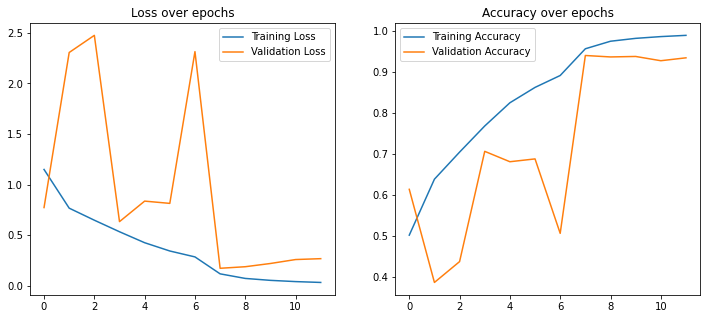

In [61]:
# code to train and evaluate the Custom AlexNet model from scratch (without the pre-trained weights)

model1 = CustomAlexNet(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001, weight_decay=1e-4)

scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

def train_epoch(epoch_index, train_loader, model, optimizer):
    running_loss = 0.0
    correct_pred = 0
    total_pred = 0

    model1.train()  # Set model to training mode
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch_index + 1} [train] Progress", unit="batch"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predictions = torch.max(outputs, 1)
        correct_pred += (predictions == labels).sum().item()
        total_pred += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    avg_acc = correct_pred / total_pred
    print(f'train Loss: {avg_loss:.4f} Acc: {avg_acc:.4f}')

    return avg_loss, avg_acc

def validate_epoch(epoch_index, val_loader, model):
    running_loss = 0.0
    correct_pred = 0
    total_pred = 0

    model1.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch_index + 1} [val] Progress", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model1(inputs)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item()
            _, predictions = torch.max(outputs, 1)
            correct_pred += (predictions == labels).sum().item()
            total_pred += labels.size(0)

    avg_loss = running_loss / len(val_loader)
    avg_acc = correct_pred / total_pred
    print(f'val Loss: {avg_loss:.4f} Acc: {avg_acc:.4f}')

    return avg_loss, avg_acc

# Training loop
num_epochs = 25
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
best_val_loss = float('inf')
patience = 5  # Early stopping patience
trigger_times = 0

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(epoch, train_loader, model1, optimizer)
    val_loss, val_acc = validate_epoch(epoch, val_loader, model1)

    # Learning rate scheduling
    scheduler.step()

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Store losses and accuracies
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss over epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over epochs')

plt.show()

In [64]:
torch.save(model1.state_dict(), 'AlexNet_38.pth') # saving the trained model

In [65]:
# classification report (val loader)
loaded_model = CustomAlexNet(num_classes=4).to(device)

loaded_model.load_state_dict(torch.load('AlexNet_38.pth'))

def evaluate_model(model, dataloader):
    model.eval() 
    true_labels = []
    predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())

    return true_labels, predictions

# Evaluate the model
true_labels, predictions = evaluate_model(loaded_model, val_loader)

# Print classification report
print(classification_report(true_labels, predictions, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

                  precision    recall  f1-score   support

    MildDemented       0.96      0.98      0.97      1331
ModerateDemented       1.00      1.00      1.00       980
     NonDemented       0.97      0.87      0.91      1422
VeryMildDemented       0.87      0.95      0.91      1364

        accuracy                           0.94      5097
       macro avg       0.95      0.95      0.95      5097
    weighted avg       0.95      0.94      0.94      5097



In [67]:
# classification report (test loader)

def evaluate_model(model, dataloader):
    model.eval() 
    true_labels = []
    predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())

    return true_labels, predictions

# Evaluate the model
true_labels, predictions = evaluate_model(loaded_model, test_loader)

# Print classification report
print(classification_report(true_labels, predictions, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

                  precision    recall  f1-score   support

    MildDemented       0.96      0.97      0.97      1352
ModerateDemented       1.00      1.00      1.00       952
     NonDemented       0.98      0.87      0.92      1461
VeryMildDemented       0.87      0.96      0.91      1334

        accuracy                           0.95      5099
       macro avg       0.95      0.95      0.95      5099
    weighted avg       0.95      0.95      0.95      5099



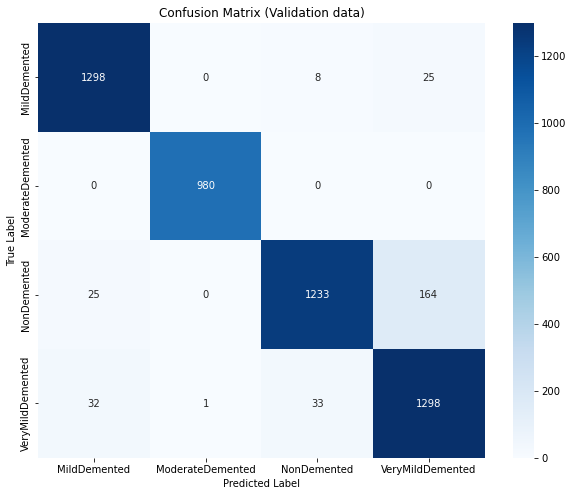

In [68]:
# Confusion Matrix on Val Loader

def get_predictions(model, dataloader):
    model.eval()  
    true_labels = []
    predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())

    return true_labels, predictions

# Evaluate the model
true_labels, predictions = get_predictions(loaded_model, val_loader)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Validation data)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

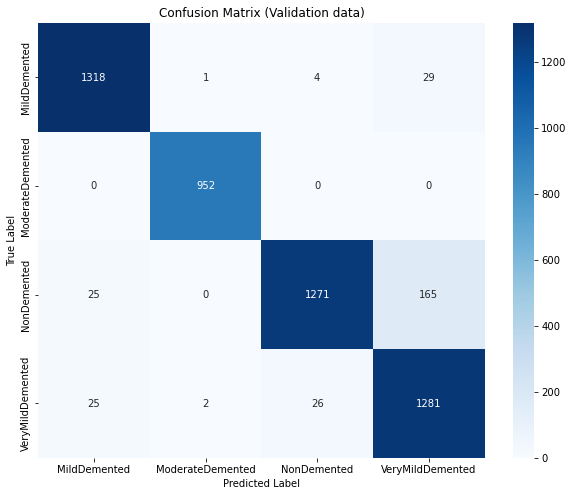

In [69]:
# Confusion Matrix on test loader (unseen data)

def get_predictions(model, dataloader):
    model.eval()  
    true_labels = []
    predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())

    return true_labels, predictions

# Evaluate the model
true_labels, predictions = get_predictions(loaded_model, test_loader)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Validation data)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

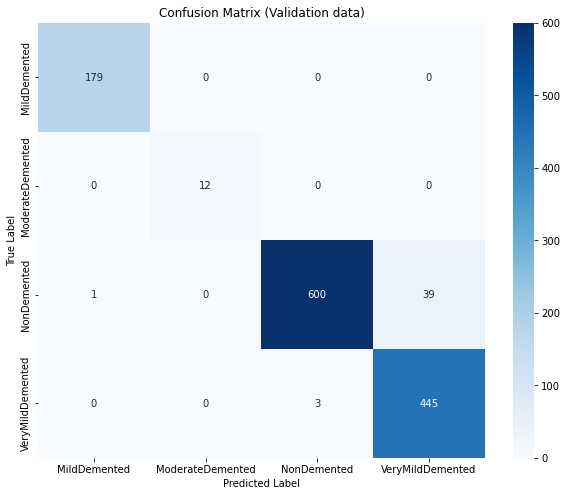

In [119]:
# Confusion Matrix on test dataset (unseen data)

test_data_dir = '/Users/savin/Desktop/FYP/Implementation/AD_Dataset/test'

preprocessed_test_dataset = datasets.ImageFolder(root=test_data_dir, transform=preprocess_transform)

test_dataset_loader = DataLoader(preprocessed_test_dataset, batch_size=32, shuffle=False)

def get_predictions(model, dataloader):
    model.eval()  
    true_labels = []
    predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())

    return true_labels, predictions

# Evaluate the model
true_labels, predictions = get_predictions(loaded_model, test_dataset_loader)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Validation data)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [124]:
def load_and_predict(image_path, model, transform, device, class_names):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        predicted_class = class_names[predicted.item()]

    return predicted_class

# Class names
class_names = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very Mild Demented']

Tk().withdraw()
image_path = filedialog.askopenfilename()

if image_path:
    predicted_class = load_and_predict(image_path, loaded_model, preprocess_transform, device, class_names)
    print(f'Predicted class: {predicted_class}')
    print(image_path)
else:
    print("No file was selected.")

2024-01-27 09:00:36.733 python[38803:5317033] +[CATransaction synchronize] called within transaction
2024-01-27 09:00:36.869 python[38803:5317033] +[CATransaction synchronize] called within transaction
2024-01-27 09:00:38.179 python[38803:5317033] +[CATransaction synchronize] called within transaction


Predicted class: Moderate Demented
/Users/savin/Desktop/FYP/Implementation/POC_Dataset/Test/ModerateDemented/28 (2).jpg


In [117]:
# predictions for the uploaded MRI images
# uploaded 10 Very Mild Demented MRI images = 10/10 correct predictions
# uploaded 10 Non Demented MRI images = 8/10 correct predictions
# uploaded 10 Moderate Demented MRI images = 10/10 correct predictions
# uploaded 10 Mild Demented MRI images = 10/10 correct predictions

In [118]:
# Save the best model locally (AlexNet Original Modified 38 layers)

model_save_path = '/Users/savin/Desktop/FYP/Implementation' 
os.makedirs(model_save_path, exist_ok=True) 
model_save_file = os.path.join(model_save_path, 'AlexNet_38.pth')

torch.save(loaded_model.state_dict(), model_save_file)

print(f'Model saved to {model_save_file}')

Model saved to /Users/savin/Desktop/FYP/Implementation/AlexNet_38.pth


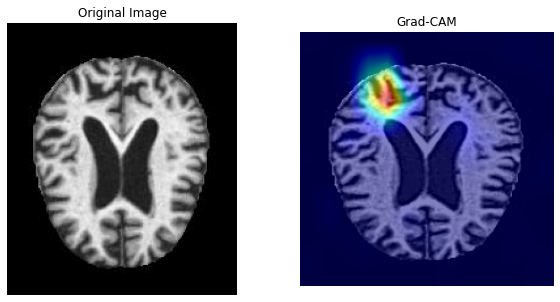

In [125]:
# Preprocessing function
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image_tensor = preprocess_transform(image).unsqueeze(0).to(device)
    return image_tensor, image

# Grad-CAM function
def apply_gradcam(model, image_tensor, target_layer):
    gradcam = GradCAM(model, target_layer)
    mask, _ = gradcam(image_tensor)
    heatmap, result = visualize_cam(mask, image_tensor)

    return heatmap, result

# Load and preprocess image
input_image_path = image_path
image_tensor, original_image = preprocess_image(input_image_path)

# Apply Grad-CAM (adjust target layer as needed)
target_layer = loaded_model.features[4]  # Example: last conv layer in features
heatmap, cam_result = apply_gradcam(loaded_model, image_tensor, target_layer)

# Visualization
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cam_result.permute(1, 2, 0).cpu().numpy())
plt.title('Grad-CAM')
plt.axis('off')

plt.show()